# Stage 1 Model: predict listing price based on listing features

In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics

from xgboost import XGBRegressor
import category_encoders as ce
import datetime
import joblib

[Python - How to Save and Load ML Models](https://www.kaggle.com/prmohanty/python-how-to-save-and-load-ml-models)

## Finalize features and target variable
- target variable is price

In [204]:
df = pd.read_csv('../../Large_Data/Listings_combined_cleaned.csv')
df.head()

,neighborhood_recoded,county,property_type_recoded,accommodates,bedrooms,beds,bathrooms,bathroom_type,minimum_nights,maximum_nights,...,neighborhood_overview_f,host_about_f,host_response_time_f,host_response_rate_f,host_acceptance_rate_f,host_neighbourhood_f,price,availability_30,availability_60,availability_90
0,Western Addition,San Francisco,Entire serviced apartment,3,1.0,2.0,1.0,private,2,30,...,1,1,1,1,1,1,161.0,7,7,10
1,Bernal Heights,San Francisco,Entire rental unit,5,2.0,3.0,1.0,private,30,60,...,1,1,1,1,1,1,235.0,30,60,90
2,Haight Ashbury,San Francisco,Private room in rental unit,2,1.0,1.0,4.0,shared,32,60,...,1,1,1,1,1,1,56.0,30,60,90
3,Haight Ashbury,San Francisco,Private room in rental unit,2,1.0,1.0,4.0,shared,32,90,...,0,1,1,1,1,1,56.0,30,60,90
4,Western Addition,San Francisco,Entire condominium (condo),4,2.0,2.0,1.5,private,7,111,...,0,1,1,1,1,1,895.0,29,59,89


In [205]:
df.shape

(9825, 39)

In [206]:
df.columns

Index(['neighborhood_recoded', 'county', 'property_type_recoded',
       'accommodates', 'bedrooms', 'beds', 'bathrooms', 'bathroom_type',
       'minimum_nights', 'maximum_nights', 'Wifi', 'Dedicated_workspace',
       'Patio_or_balcony', 'Backyard', 'BBQ_grill', 'Outdoor_furniture',
       'Indoor_fireplace', 'Private_entrance', 'Pool', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'neighborhood_overview_f', 'host_about_f', 'host_response_time_f',
       'host_response_rate_f', 'host_acceptance_rate_f',
       'host_neighbourhood_f', 'price', 'availability_30', 'availability_60',
       'availability_90'],
      dtype='object')

In [207]:
# create
X = df.drop(columns=['price','availability_30', 'availability_60','availability_90'])
y = df['price']



# build the model
m1_pipe_xgb_base_random = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('xgb', XGBRegressor(n_estimators=400, max_depth=4, eta=0.03, reg_lambda=30, reg_alpha=30, random_state=42, n_jobs=-1))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7368, 35), (7368,), (2457, 35), (2457,))

In [208]:
# create train for EDA
train = df.loc[df.index.isin(X.index), :]
print(train.shape)
train.head()

(9825, 39)


,neighborhood_recoded,county,property_type_recoded,accommodates,bedrooms,beds,bathrooms,bathroom_type,minimum_nights,maximum_nights,...,neighborhood_overview_f,host_about_f,host_response_time_f,host_response_rate_f,host_acceptance_rate_f,host_neighbourhood_f,price,availability_30,availability_60,availability_90
0,Western Addition,San Francisco,Entire serviced apartment,3,1.0,2.0,1.0,private,2,30,...,1,1,1,1,1,1,161.0,7,7,10
1,Bernal Heights,San Francisco,Entire rental unit,5,2.0,3.0,1.0,private,30,60,...,1,1,1,1,1,1,235.0,30,60,90
2,Haight Ashbury,San Francisco,Private room in rental unit,2,1.0,1.0,4.0,shared,32,60,...,1,1,1,1,1,1,56.0,30,60,90
3,Haight Ashbury,San Francisco,Private room in rental unit,2,1.0,1.0,4.0,shared,32,90,...,0,1,1,1,1,1,56.0,30,60,90
4,Western Addition,San Francisco,Entire condominium (condo),4,2.0,2.0,1.5,private,7,111,...,0,1,1,1,1,1,895.0,29,59,89


In [209]:
X_train.head()

,neighborhood_recoded,county,property_type_recoded,accommodates,bedrooms,beds,bathrooms,bathroom_type,minimum_nights,maximum_nights,...,review_scores_value,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,neighborhood_overview_f,host_about_f,host_response_time_f,host_response_rate_f,host_acceptance_rate_f,host_neighbourhood_f
4852,Redwood City,San Mateo,Private room in residential home,4,2.0,2.0,1.0,shared,15,1125,...,4.81,63,0,0,1,0,1,1,1,1
4052,Noe Valley,San Francisco,Private room in residential home,2,1.0,1.0,1.5,shared,2,7,...,5.00,6,6,2,0,1,0,0,0,1
8104,San Jose,Santa Clara,Private room in residential home,2,1.0,1.0,3.0,shared,2,1125,...,4.87,67,18,1,1,1,1,1,1,1
1396,Bernal Heights,San Francisco,Private room in guest suite,2,1.0,1.0,1.0,private,2,14,...,4.90,141,11,3,0,0,0,0,0,1
7150,San Jose,Santa Clara,Private room in residential home,2,1.0,1.0,1.0,private,1,2,...,4.90,105,3,0,1,1,1,1,1,0


## EDA

In [8]:
train.describe()

,accommodates,bedrooms,beds,bathrooms,minimum_nights,maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,...,neighborhood_overview_f,host_about_f,host_response_time_f,host_response_rate_f,host_acceptance_rate_f,host_neighbourhood_f,price,availability_30,availability_60,availability_90
count,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,...,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000
mean,3.480305,1.593181,2.028702,1.416896,13.044784,569.837150,4.764960,4.814749,4.757261,4.880370,...,0.731501,0.707277,0.828601,0.828601,0.861272,0.875623,178.069313,11.231552,27.325293,46.218626
std,2.415604,0.975522,1.569959,0.826013,30.318371,514.153885,0.407623,0.379128,0.420152,0.327301,...,0.443201,0.455035,0.376877,0.376877,0.345680,0.330027,148.448029,11.269745,22.415682,32.691111
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,30.000000,4.710000,4.790000,4.690000,4.890000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,81.000000,0.000000,1.000000,13.000000
50%,2.000000,1.000000,1.000000,1.000000,3.000000,365.000000,4.880000,4.930000,4.890000,4.970000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,134.000000,8.000000,27.000000,51.000000
75%,4.000000,2.000000,3.000000,2.000000,30.000000,1125.000000,5.000000,5.000000,5.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,219.000000,22.000000,49.000000,78.000000
max,16.000000,9.000000,27.000000,10.000000,1125.000000,1125.000000,5.000000,5.000000,5.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1000.000000,30.000000,60.000000,90.000000


In [9]:
# Price

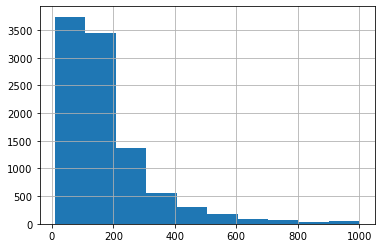

In [10]:
train['price'].hist();

Text(0.5, 1.1, 'Price per night by county')

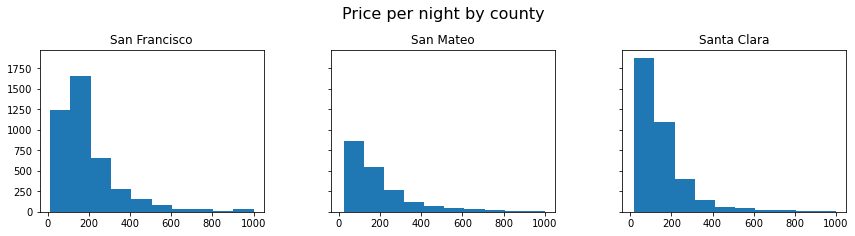

In [11]:
train.hist(column='price', by='county', figsize=(14,3), layout=(1,3), xrot=0, legend=False, sharex=True, sharey=True)
;
plt.suptitle('Price per night by county', x=0.5, y=1.1, fontsize=16)
#plt.savefig('../Plots/price_bycounty_hist2.png')

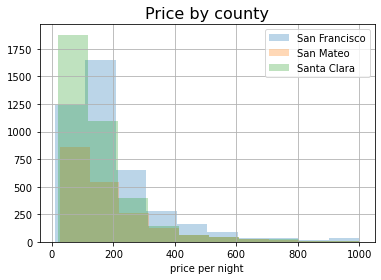

In [12]:
train.groupby('county')['price'].hist(alpha=0.3, legend=True)
plt.legend()
plt.title('Price by county', fontsize=16)
plt.xlabel('price per night');

#plt.savefig('../Plots/price_bycounty_hist.png')

''

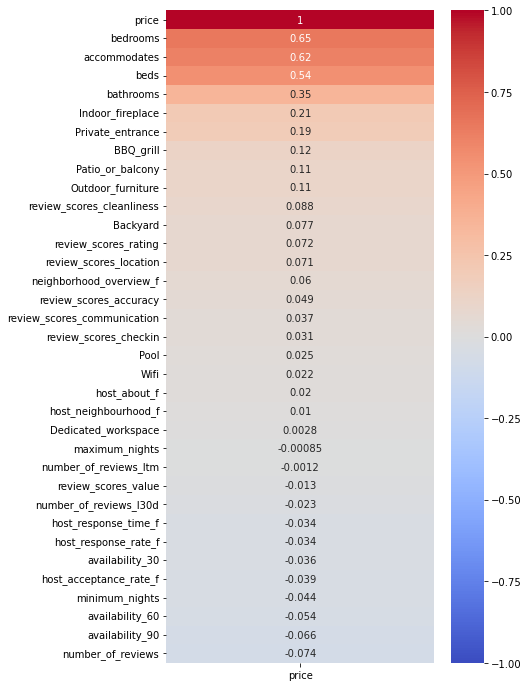

In [13]:
plt.figure(figsize=(6,12))
sns.heatmap(train.corr()[['price']].sort_values('price',ascending=False), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
; 

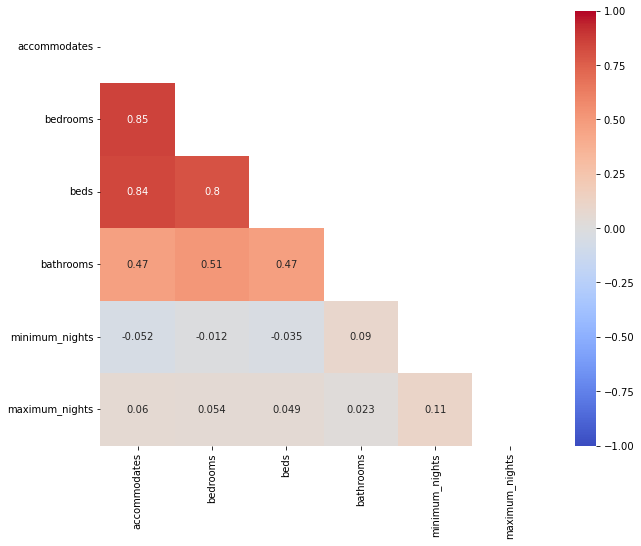

In [14]:
mask = np.zeros_like(train[['accommodates','bedrooms','beds','bathrooms','bathroom_type','minimum_nights','maximum_nights']].corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10,8))
sns.heatmap(train[['accommodates','bedrooms','beds','bathrooms','bathroom_type','minimum_nights','maximum_nights']].corr(), 
            mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1);

Text(0.5, 0.98, 'Listing price by size related features')

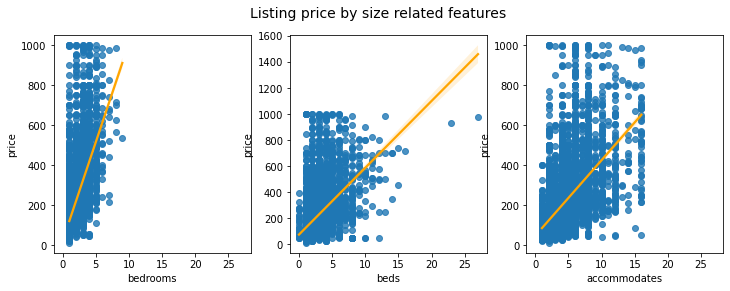

In [15]:
figure, axes = plt.subplots(1, 3, figsize=(12,4), sharex=True)

ax1 = sns.regplot(x='bedrooms',     y='price', data=train, ax=axes[0], line_kws={'color':'orange'})
ax2 = sns.regplot(x='beds',         y='price', data=train, ax=axes[1], line_kws={'color':'orange'})
ax3 = sns.regplot(x='accommodates', y='price', data=train, ax=axes[2], line_kws={'color':'orange'})

plt.suptitle('Listing price by size related features', fontsize=14)

**Observations**: 
1. Listing price is correlated with the number of bedrooms and beds and the number of people it can accommodate. 
2. The number of beds, bedrooms and people the unit can accommodate are highly correlated.

In [16]:
# price by categorical 

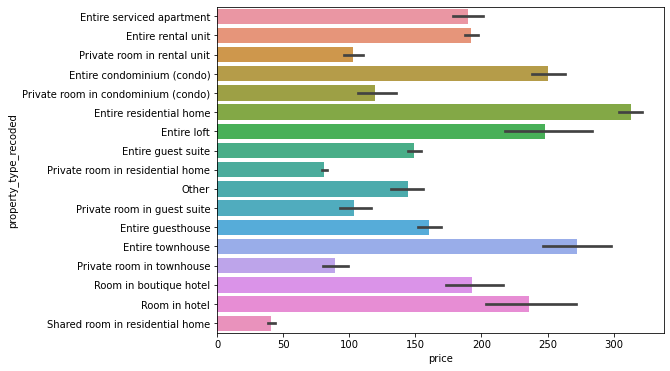

In [17]:
plt.figure(figsize=(8, 6))
sns.barplot(y='property_type_recoded', x='price', data=train, orient='h');

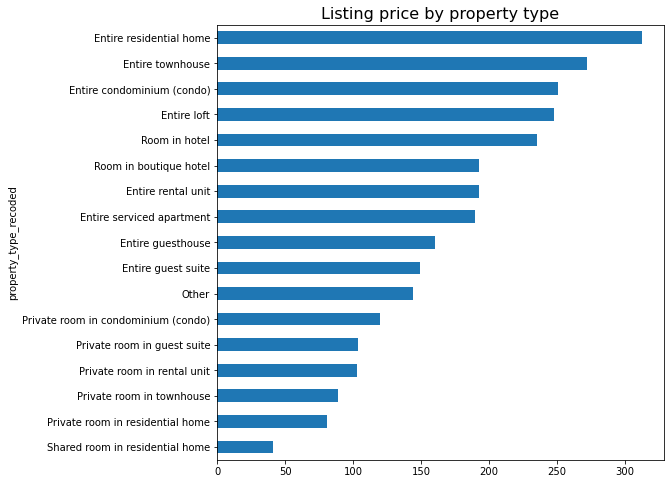

In [18]:
plt.figure(figsize=(8,8))
train.groupby('property_type_recoded').mean()['price'].sort_values(ascending=True).plot.barh()
plt.title('Listing price by property type', fontsize=16); 

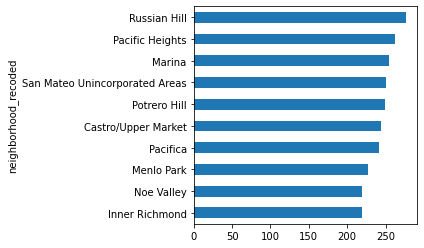

In [19]:
plt.figure(figsize=(4,4))
train.groupby('neighborhood_recoded').mean()['price'].sort_values(ascending=True).tail(10).plot.barh(); 

## Modeling

In [210]:
list(X_train['property_type_recoded'].unique())

['Private room in residential home',
 'Private room in guest suite',
 'Entire guest suite',
 'Room in boutique hotel',
 'Private room in condominium (condo)',
 'Entire residential home',
 'Entire rental unit',
 'Entire loft',
 'Entire guesthouse',
 'Entire serviced apartment',
 'Other',
 'Private room in rental unit',
 'Room in hotel',
 'Entire condominium (condo)',
 'Entire townhouse',
 'Private room in townhouse',
 'Shared room in residential home']

In [211]:
print(X_train.shape)
X_train.head()

(7368, 35)


,neighborhood_recoded,county,property_type_recoded,accommodates,bedrooms,beds,bathrooms,bathroom_type,minimum_nights,maximum_nights,...,review_scores_value,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,neighborhood_overview_f,host_about_f,host_response_time_f,host_response_rate_f,host_acceptance_rate_f,host_neighbourhood_f
4852,Redwood City,San Mateo,Private room in residential home,4,2.0,2.0,1.0,shared,15,1125,...,4.81,63,0,0,1,0,1,1,1,1
4052,Noe Valley,San Francisco,Private room in residential home,2,1.0,1.0,1.5,shared,2,7,...,5.00,6,6,2,0,1,0,0,0,1
8104,San Jose,Santa Clara,Private room in residential home,2,1.0,1.0,3.0,shared,2,1125,...,4.87,67,18,1,1,1,1,1,1,1
1396,Bernal Heights,San Francisco,Private room in guest suite,2,1.0,1.0,1.0,private,2,14,...,4.90,141,11,3,0,0,0,0,0,1
7150,San Jose,Santa Clara,Private room in residential home,2,1.0,1.0,1.0,private,1,2,...,4.90,105,3,0,1,1,1,1,1,0


In [212]:
# save m1_X_train
X_train.to_csv('../Data/m1_X_train.csv')

In [213]:
# get the data shape after one hot encoding 

# https://contrib.scikit-learn.org/category_encoders/onehot.html
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')

X_train_ohe = ohe.fit_transform(X_train, use_cat_names=True)
X_train_ohe.shape

(7368, 98)

In [24]:
#X_train_ohe.columns

### Baseline model

In [37]:
# train set
print(f'Average listing price (train): {round(y_train.mean(), 2)}')
price_pred_base_train = np.full((y_train.shape[0], 1), y_train.mean())

price_pred_base_mse_train = metrics.mean_squared_error(y_train, price_pred_base_train)
print(f'price_pred_base_mse_train: {round(price_pred_base_mse_train, 4)}')
print()

# test set
print(f'Average listing price (test): {round(y_test.mean(), 2)}')
price_pred_base_test = np.full((y_test.shape[0], 1), y_test.mean())

price_pred_base_mse_test = metrics.mean_squared_error(y_test, price_pred_base_test)
print(f'price_pred_base_mse_test: {round(price_pred_base_mse_test, 4)}')

Average listing price (train): 177.53
price_pred_base_mse_train: 21698.0376

Average listing price (test): 179.68
price_pred_base_mse_test: 23040.302


### Random Forest regressor

#### Default parameter values

In [38]:
m1_pipe_rf_base = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

m1_pipe_rf_base.fit(X_train, y_train)
m1_pipe_rf_base_pred_train = m1_pipe_rf_base.predict(X_train)
m1_pipe_rf_base_pred_test = m1_pipe_rf_base.predict(X_test)

m1_pipe_rf_base_R2_train = m1_pipe_rf_base.score(X_train, y_train)
m1_pipe_rf_base_R2_test = m1_pipe_rf_base.score(X_test, y_test)
print('m1_pipe_rf_base_R2_train: ', round(m1_pipe_rf_base_R2_train, 4))
print('m1_pipe_rf_base_R2_test: ', round(m1_pipe_rf_base_R2_test, 4))

m1_pipe_rf_base_mse_train = metrics.mean_squared_error(y_train, m1_pipe_rf_base_pred_train)
m1_pipe_rf_base_mse_test = metrics.mean_squared_error(y_test, m1_pipe_rf_base_pred_test)
print('m1_pipe_rf_base_mse_train', round(m1_pipe_rf_base_mse_train, 4))
print('m1_pipe_rf_base_mse_test', round(m1_pipe_rf_base_mse_test, 4))

m1_pipe_rf_base_R2_train:  0.9504
m1_pipe_rf_base_R2_test:  0.6592
m1_pipe_rf_base_mse_train 1076.3492
m1_pipe_rf_base_mse_test 7851.2171


In [40]:
m1_pipe_rf_base_feature_importance = pd.DataFrame({'feature': m1_pipe_rf_base['ohe'].get_feature_names(),
                                         'importance': m1_pipe_rf_base['rf'].feature_importances_})

m1_pipe_rf_base_feature_importance.to_csv('../Data/m1_pipe_rf_base_feature_importance.csv', index=False)
m1_pipe_rf_base_feature_importance.sort_values('importance', ascending=False).head(30)

,feature,importance
66,bedrooms,0.393363
68,bathrooms,0.067199
71,minimum_nights,0.039243
82,review_scores_rating,0.030255
88,review_scores_value,0.030124
87,review_scores_location,0.027378
89,number_of_reviews,0.026652
72,maximum_nights,0.025495
65,accommodates,0.024657
90,number_of_reviews_ltm,0.022880


In [65]:
np.random.random(X_train.shape[0])

array([0.04304163, 0.6937308 , 0.03687303, ..., 0.95656244, 0.59334435,
       0.43907379])

In [ ]:
### Default pipeline with a completely random variable - to do!!!

X_train_random 

In [ ]:
m1_pipe_rf_base = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

m1_pipe_rf_base.fit(X_train, y_train)
m1_pipe_rf_base_pred_train = m1_pipe_rf_base.predict(X_train)
m1_pipe_rf_base_pred_test = m1_pipe_rf_base.predict(X_test)

m1_pipe_rf_base_R2_train = m1_pipe_rf_base.score(X_train, y_train)
m1_pipe_rf_base_R2_test = m1_pipe_rf_base.score(X_test, y_test)
print('m1_pipe_rf_base_R2_train: ', round(m1_pipe_rf_base_R2_train, 4))
print('m1_pipe_rf_base_R2_test: ', round(m1_pipe_rf_base_R2_test, 4))

m1_pipe_rf_base_mse_train = metrics.mean_squared_error(y_train, m1_pipe_rf_base_pred_train)
m1_pipe_rf_base_mse_test = metrics.mean_squared_error(y_test, m1_pipe_rf_base_pred_test)
print('m1_pipe_rf_base_mse_train', round(m1_pipe_rf_base_mse_train, 4))
print('m1_pipe_rf_base_mse_test', round(m1_pipe_rf_base_mse_test, 4))

In [ ]:
m1_pipe_rf_base_feature_importance = pd.DataFrame({'feature': m1_pipe_rf_base['ohe'].get_feature_names(),
                                         'importance': m1_pipe_rf_base['rf'].feature_importances_})

m1_pipe_rf_base_feature_importance.to_csv('../Data/m1_pipe_rf_base_feature_importance.csv', index=False)
m1_pipe_rf_base_feature_importance.sort_values('importance', ascending=False).head(30)

#### GridSearchCV

In [153]:
m1_pipe_rf = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

m1_pipe_rf_params = {
    'rf__n_estimators': [400, 500, 600, 700, 800],
    'rf__max_depth': [6, 8, 10, 12, 14, 16, 18, 20],
    'rf__min_samples_split': [10, 20],
    'rf__min_samples_leaf': [5],
    #'rf__ccp_alpha': [0.0, 0.05, 0.1],
    'rf__max_features': [15, 30, 60, 90]
}
    
m1_gs_rf = GridSearchCV(m1_pipe_rf,
                        m1_pipe_rf_params,
                        cv=5)
        
print(datetime.datetime.now())

m1_gs_rf.fit(X_train, y_train)

print(datetime.datetime.now())
    

2022-02-03 17:10:19.385767
2022-02-03 18:23:56.538816


In [155]:
# predict
m1_gs_rf_pred_train = m1_gs_rf.predict(X_train)
m1_gs_rf_pred_test = m1_gs_rf.predict(X_test)

# evaluate
m1_gs_rf_R2_train = m1_gs_rf.score(X_train, y_train)
m1_gs_rf_R2_test = m1_gs_rf.score(X_test, y_test)
print('m1_gs_rf_R2_train: ', round(m1_gs_rf_R2_train, 4))
print('m1_gs_rf_R2_test:  ', round(m1_gs_rf_R2_test, 4))

m1_gs_rf_mse_train = metrics.mean_squared_error(y_train, m1_gs_rf_pred_train)
m1_gs_rf_mse_test = metrics.mean_squared_error(y_test, m1_gs_rf_pred_test)
print('m1_gs_rf_mse_train: ', round(m1_gs_rf_mse_train, 4))
print('m1_gs_rf_mse_test:  ', round(m1_gs_rf_mse_test, 4))

m1_gs_rf.best_estimator_

m1_gs_rf_R2_train:  0.8195
m1_gs_rf_R2_test:   0.6489
m1_gs_rf_mse_train:  3916.1887
m1_gs_rf_mse_test:   8090.0729


Pipeline(steps=[('ohe',
                 OneHotEncoder(cols=['neighborhood_recoded', 'county',
                                     'property_type_recoded', 'bathroom_type'],
                               use_cat_names=True)),
                ('rf',
                 RandomForestRegressor(max_depth=18, max_features=60,
                                       min_samples_leaf=5, min_samples_split=10,
                                       n_estimators=400, n_jobs=-1,
                                       random_state=42))])

In [159]:
m1_gs_rf_feature_importance = pd.DataFrame({'feature': m1_gs_rf.best_estimator_['ohe'].get_feature_names(),
                                         'importance': m1_gs_rf.best_estimator_['rf'].feature_importances_})

m1_gs_rf_feature_importance.to_csv('../Data/m1_gs_rf_feature_importance.csv', index=False)
m1_gs_rf_feature_importance.sort_values('importance', ascending=False).head(30)

,feature,importance
66,bedrooms,0.333338
65,accommodates,0.133263
68,bathrooms,0.064129
67,beds,0.043420
71,minimum_nights,0.036626
82,review_scores_rating,0.030064
88,review_scores_value,0.027649
87,review_scores_location,0.026085
72,maximum_nights,0.024939
70,bathroom_type_private,0.022662


In [160]:
# correlation between actual and predicted prices

import scipy
scipy.stats.pearsonr(y_test, m1_gs_rf_pred_test)

(0.8099105230959827, 0.0)

#### Save (and reload) gs_rf model with Joblib

In [161]:
import joblib

# save m1_gs_rf
m1_gs_rf_joblib_filename = '../Models/m1_gs_rf_joblib.pkl'

joblib.dump(m1_gs_rf, m1_gs_rf_joblib_filename)

# reload 
#m1_gs_rf_joblib = joblib.load(m1_gs_rf_joblib_filename)

# predict & evaluate
#m1_gs_rf_joblib_pred_test = m1_gs_rf_joblib.predict(X_test)
#m1_gs_rf_joblib.score(X_test, y_test)

['../Models/m1_gs_rf_joblib.pkl']

### XGBoost 

#### Default parameter values

In [214]:
m1_pipe_xgb_base = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('xgb', XGBRegressor(random_state=42, n_jobs=1))
])

m1_pipe_xgb_base.fit(X_train, y_train)

m1_pipe_xgb_base_pred_train = m1_pipe_xgb_base.predict(X_train)
m1_pipe_xgb_base_pred_test = m1_pipe_xgb_base.predict(X_test)


m1_pipe_xgb_base_R2_train = m1_pipe_xgb_base.score(X_train, y_train)
m1_pipe_xgb_base_R2_test = m1_pipe_xgb_base.score(X_test, y_test)
print('m1_pipe_xgb_base_R2_train: ', round(m1_pipe_xgb_base_R2_train, 4))
print('m1_pipe_xgb_base_R2_test: ', round(m1_pipe_xgb_base_R2_test, 4))

m1_pipe_xgb_base_mse_train = metrics.mean_squared_error(y_train, m1_pipe_xgb_base_pred_train)
m1_pipe_xgb_base_mse_test = metrics.mean_squared_error(y_test, m1_pipe_xgb_base_pred_test)
print('m1_pipe_xgb_base_mse_train: ', round(m1_pipe_xgb_base_mse_train, 4))
print('m1_pipe_xgb_base_mse_test: ', round(m1_pipe_xgb_base_mse_test, 4))

# save m1_gs_rf

# import joblib
m1_pipe_xgb_base_joblib_filename = '../Models/m1_pipe_xgb_base_joblib.pkl'

joblib.dump(m1_pipe_xgb_base, m1_pipe_xgb_base_joblib_filename)

m1_pipe_xgb_base_R2_train:  0.9406
m1_pipe_xgb_base_R2_test:  0.6595
m1_pipe_xgb_base_mse_train:  1288.0335
m1_pipe_xgb_base_mse_test:  7844.9063


['../Models/m1_pipe_xgb_base_joblib.pkl']

#### Default parameter values + a completely random column

In [238]:


# train model
print(datetime.datetime.now())
m1_pipe_xgb_base_random.fit(X_train_random, y_train)
print(datetime.datetime.now())
print()

# predict
m1_pipe_xgb_base_random_pred_train = m1_pipe_xgb_base_random.predict(X_train_random)
m1_pipe_xgb_base_random_pred_test = m1_pipe_xgb_base_random.predict(X_test_random)

# evaluate
m1_pipe_xgb_base_random_R2_train = m1_pipe_xgb_base_random.score(X_train_random, y_train)
m1_pipe_xgb_base_random_R2_test = m1_pipe_xgb_base_random.score(X_test_random, y_test)
print('m1_pipe_xgb_base_random_R2_train: ', round(m1_pipe_xgb_base_random_R2_train, 4))
print('m1_pipe_xgb_base_random_R2_test: ', round(m1_pipe_xgb_base_random_R2_test, 4))

m1_pipe_xgb_base_random_mse_train = metrics.mean_squared_error(y_train, m1_pipe_xgb_base_random_pred_train)
m1_pipe_xgb_base_random_mse_test = metrics.mean_squared_error(y_test, m1_pipe_xgb_base_random_pred_test)
print('m1_pipe_xgb_base_random_mse_train', round(m1_pipe_xgb_base_random_mse_train, 4))
print('m1_pipe_xgb_base_random_mse_test', round(m1_pipe_xgb_base_random_mse_test, 4))

2022-02-04 20:54:44.730050
2022-02-04 20:54:48.220212

m1_pipe_xgb_base_random_R2_train:  0.716
m1_pipe_xgb_base_random_R2_test:  0.6537
m1_pipe_xgb_base_random_mse_train 6163.1506
m1_pipe_xgb_base_random_mse_test 7978.9377


In [241]:
# feature importance
m1_pipe_xgb_base_random_feature_importance = pd.DataFrame({'feature': m1_pipe_xgb_base_random['ohe'].get_feature_names(),
                                             'importance': m1_pipe_xgb_base_random['xgb'].feature_importances_})

m1_pipe_xgb_base_random_feature_importance.to_csv('../Data/m1_pipe_xgb_base_random_feature_importance.csv')
m1_pipe_xgb_base_random_feature_importance.sort_values('importance', ascending=False).head(21)

# there are 70 features that are more important than the 'random' column.

,feature,importance
66,bedrooms,0.366064
65,accommodates,0.054910
69,bathroom_type_shared,0.046248
46,county_San Francisco,0.031099
48,property_type_recoded_Private room in resident...,0.026049
68,bathrooms,0.023206
47,county_Santa Clara,0.021968
28,neighborhood_recoded_Sunnyvale,0.020533
79,Indoor_fireplace,0.017610
71,minimum_nights,0.015238


In [259]:
# retrain the model with top 70 features 

# top-70 feature list
feature_list = m1_pipe_xgb_base_random_feature_importance.sort_values('importance', ascending=False).head(50)['feature']
feature_list = [feature for feature in feature_list if feature != 'random']

# create the X_train with only these features
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')
X_train_ohe = ohe.fit_transform(X_train)
X_train_ohe_top = X_train_ohe[feature_list].copy()

X_test_ohe = ohe.transform(X_test)
X_test_ohe_top = X_test_ohe[feature_list].copy()

# build this model
m1_pipe_xgb_base_top = Pipeline([
    #('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('xgb', XGBRegressor(n_estimators=400, max_depth=4, eta=0.03, reg_lambda=30, reg_alpha=30, 
                                  random_state=42, n_jobs=-1))
])

# train model
print(datetime.datetime.now())
m1_pipe_xgb_base_top.fit(X_train_ohe_top, y_train)
print(datetime.datetime.now())
print()

# predict
m1_pipe_xgb_base_top_pred_train = m1_pipe_xgb_base_top.predict(X_train_ohe_top)
m1_pipe_xgb_base_top_pred_test = m1_pipe_xgb_base_top.predict(X_test_ohe_top)

# evaluate
m1_pipe_xgb_base_top_R2_train = m1_pipe_xgb_base_top.score(X_train_ohe_top, y_train)
m1_pipe_xgb_base_top_R2_test = m1_pipe_xgb_base_top.score(X_test_ohe_top, y_test)
print('m1_pipe_xgb_base_top_R2_train: ', round(m1_pipe_xgb_base_top_R2_train, 4))
print('m1_pipe_xgb_base_top_R2_test: ', round(m1_pipe_xgb_base_top_R2_test, 4))

m1_pipe_xgb_base_top_mse_train = metrics.mean_squared_error(y_train, m1_pipe_xgb_base_top_pred_train)
m1_pipe_xgb_base_top_mse_test = metrics.mean_squared_error(y_test, m1_pipe_xgb_base_top_pred_test)
print('m1_pipe_xgb_base_top_mse_train', round(m1_pipe_xgb_base_top_mse_train, 4))
print('m1_pipe_xgb_base_top_mse_test', round(m1_pipe_xgb_base_top_mse_test, 4))


2022-02-04 21:30:15.306871
2022-02-04 21:30:17.539361

m1_pipe_xgb_base_top_R2_train:  0.7116
m1_pipe_xgb_base_top_R2_test:  0.6572
m1_pipe_xgb_base_top_mse_train 6258.234
m1_pipe_xgb_base_top_mse_test 7899.2908


In [266]:
# feature importance
m1_pipe_xgb_base_top_feature_importance = pd.DataFrame({'feature': feature_list,
                                             'importance': m1_pipe_xgb_base_top['xgb'].feature_importances_})

m1_pipe_xgb_base_top_feature_importance.to_csv('../Data/m1_pipe_xgb_base_top_feature_importance.csv')
m1_pipe_xgb_base_top_feature_importance.sort_values('importance', ascending=False).head(30)

# There are 43 features that are more important than 'random'.

,feature,importance
0,bedrooms,0.398250
2,bathroom_type_shared,0.060820
1,accommodates,0.056989
3,county_San Francisco,0.035631
5,bathrooms,0.027053
4,property_type_recoded_Private room in resident...,0.026216
7,neighborhood_recoded_Sunnyvale,0.025130
6,county_Santa Clara,0.022248
8,Indoor_fireplace,0.019076
9,minimum_nights,0.017149


#### GridSearchCV - to run!!!

In [270]:
# build the model
m1_pipe_xgb = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('xgb', XGBRegressor(random_state=42, n_jobs=-1))
])

m1_pipe_xgb_params = {
    'xgb__n_estimators': [300,400,500],
    'xgb__eta': [0.02, 0.03, 0.05],
    'xgb__reg_lambda': [20, 30],
    #'xgb__reglalpha': [20, 30],
    'xgb__max_depth': [4,5,6,7]
}

m1_gs_xgb = GridSearchCV(m1_pipe_xgb,
                         m1_pipe_xgb_params, 
                         cv = 5)

# train the model
print(datetime.datetime.now())
m1_gs_xgb.fit(X_train, y_train)
print(datetime.datetime.now())
print()

# predict
m1_gs_xgb_pred_train = m1_gs_xgb.predict(X_train)
m1_gs_xgb_pred_test = m1_gs_xgb.predict(X_test)

# evaluate
m1_gs_xgb_R2_train = m1_gs_xgb.score(X_train, y_train)
m1_gs_xgb_R2_test = m1_gs_xgb.score(X_test, y_test)
print(f'm1_gs_xgb_R2_train: {m1_gs_xgb_R2_train}')
print(f'm1_gs_xgb_R2_test: {m1_gs_xgb_R2_test}')

m1_gs_xgb_mse_train = metrics.mean_squared_error(y_train, m1_gs_xgb_pred_train)
m1_gs_xgb_mse_test = metrics.mean_squared_error(y_test, m1_gs_xgb_pred_test)
print(f'm1_gs_xgb_mse_train: {m1_gs_xgb_mse_train}')
print(f'm1_gs_xgb_mse_test: {m1_gs_xgb_mse_test}')

m1_gs_xgb.best_estimator_

2022-02-04 22:08:12.553737
2022-02-04 23:05:45.604347

m1_gs_xgb_R2_train: 0.842880722531512
m1_gs_xgb_R2_test: 0.6903347642978348
m1_gs_xgb_mse_train: 3409.1799855794065
m1_gs_xgb_mse_test: 7134.780549663837


Pipeline(steps=[('ohe',
                 OneHotEncoder(cols=['neighborhood_recoded', 'county',
                                     'property_type_recoded', 'bathroom_type'],
                               use_cat_names=True)),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              eta=0.05, gamma=0, gpu_id=-1,
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.0500000007, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=500,
                              n_jobs=-1, num_parallel_tree=1, predictor='auto',
                              random_state=42, reg_alpha=0, reg_lambda=20,
               

In [273]:
# feature importance
m1_gs_xgb_feature_importance = pd.DataFrame({'feature': m1_gs_xgb.best_estimator_['ohe'].get_feature_names(),
                                         'importance': m1_gs_xgb.best_estimator_['xgb'].feature_importances_})

m1_gs_xgb_feature_importance.to_csv('../Data/m1_gs_xgb_feature_importance.csv')
m1_gs_xgb_feature_importance.sort_values('importance', ascending=False).head(20)

# There are ?? features that are more important than the 'random' column.

,feature,importance
66,bedrooms,0.368098
46,county_San Francisco,0.043073
65,accommodates,0.038213
69,bathroom_type_shared,0.026371
68,bathrooms,0.024121
47,county_Santa Clara,0.020158
48,property_type_recoded_Private room in resident...,0.016112
21,neighborhood_recoded_San Mateo Unincorporated ...,0.013475
23,neighborhood_recoded_Nob Hill,0.012149
71,minimum_nights,0.011549


In [272]:
# retrain the model with top 70 features 

# top-70 feature list
feature_list = m1_gs_xgb_feature_importance.sort_values('importance', ascending=False).head(50)['feature']
feature_list = [feature for feature in feature_list if feature != 'random']

# create the X_train with only these features
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')
X_train_ohe = ohe.fit_transform(X_train)
X_train_ohe_top = X_train_ohe[feature_list].copy()

X_test_ohe = ohe.transform(X_test)
X_test_ohe_top = X_test_ohe[feature_list].copy()


# build the model
m1_pipe_xgb_top = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('xgb', XGBRegressor(random_state=42, n_jobs=-1))
])

m1_gs_xgb_top_params = {
    'xgb__n_estimators': [300,400,500],
    'xgb__eta': [0.02, 0.03, 0.05],
    'xgb__reg_lambda': [20, 30],
    #'xgb__reglalpha': [20, 30],
    'xgb__max_depth': [4,5,6,7]
}

m1_gs_xgb_top = GridSearchCV(m1_pipe_xgb_top,
                         m1_gs_xgb_top_params, 
                         cv = 5)

# train the model
print(datetime.datetime.now())
m1_gs_xgb_top_.fit(X_train_ohe_top, y_train)
print(datetime.datetime.now())
print()

# predict
m1_gs_xgb_top_pred_train = m1_gs_xgb_top.predict(X_train_ohe_top)
m1_gs_xgb_top_pred_test = m1_gs_xgb_top.predict(X_test_ohe_top)

# evaluate
m1_gs_xgb_top_R2_train = m1_gs_xgb_top.score(X_train_ohe_top, y_train)
m1_gs_xgb_top_R2_test = m1_gs_xgb_top.score(X_test_ohe_top, y_test)
print(f'm1_gs_xgb_top_R2_train: {m1_gs_xgb_top_R2_train}')
print(f'm1_gs_xgb_top_R2_test: {m1_gs_xgb_top_R2_test}')

m1_gs_xgb_top_mse_train = metrics.mean_squared_error(y_train, m1_gs_xgb_top_pred_train)
m1_gs_xgb_top_mse_test = metrics.mean_squared_error(y_test, m1_gs_xgb_top_pred_test)
print(f'm1_gs_xgb_top_mse_train: {m1_gs_xgb_top_mse_train}')
print(f'm1_gs_xgb_top_mse_test: {m1_gs_xgb_top_mse_test}')

m1_gs_xgb.best_estimator_

2022-02-04 23:05:45.937628


NameError: name 'm1_gs_xgbtop_' is not defined

#### Save and reload m1_gs_xgb with joblib

In [ ]:
# import joblib

# save m1_gs_rf
m1_gs_xgb_joblib_filename = '../Models/m1_gs_XGBoost_joblib.pkl'

joblib.dump(m1_gs_xgb, m1_gs_xgb_joblib_filename)

# reload 
m1_gs_xgb_joblib = joblib.load(m1_gs_xgb_joblib_filename)
# m1_gs_xgb_joblib

# predict & evaluate
m1_gs_xgb_joblib_pred_test = m1_gs_xgb_joblib.predict(X_test)
round(m1_gs_xgb_joblib.score(X_test, y_test), 4)

In [ ]:
X_train.columns

## Predict with mock input data

In [164]:
input_data = {'county': 'San Francisco',
              'neighborhood_recoded': 'Russian Hill', 
              'property_type_recoded': 'Entire residential home', 
              'accommodates': 6, 
              'bedrooms': 3, 
              'beds': 3,
              'bathrooms': 2.5, 
              'bathroom_type': 'private', 
              'minimum_nights': 1, 
              'maximum_nights': 3,
              'Wifi': 1, 
              'Dedicated_workspace': 0,
              'Private_entrance': 0, 
              'Patio_or_balcony': 1, 
              'Backyard': 1, 
              'BBQ_grill': 1, 
              'Outdoor_furniture': 1,
              'Indoor_fireplace': 0, 
              'Pool': 1, 
              'review_scores_rating': 4.8,
              'review_scores_accuracy': 4.8, 
              'review_scores_cleanliness': 4.8,
              'review_scores_checkin': 4.8,
              'review_scores_communication': 4.8,
              'review_scores_location': 4.8, 
              'review_scores_value': 4.8, 
              'number_of_reviews': 4.8,
              'number_of_reviews_ltm': 20, 
              'number_of_reviews_l30d': 5,
              'neighborhood_overview_f': 1, 
              'host_about_f': 1, 
              'host_response_time_f': 0,
              'host_response_rate_f': 0, 
              'host_acceptance_rate_f': 0,
              'host_neighbourhood_f': 0
}
input_data_df = pd.DataFrame(input_data, index=[0])

In [165]:
# load m1_gs_rf
m1_gs_rf_joblib_filename = '../Models/m1_gs_rf_joblib.pkl'

m1_gs_rf_joblib = joblib.load(m1_gs_rf_joblib_filename)
# m1_gs_rf_joblib

# predict & evaluate
m1_gs_rf_joblib_pred_input = m1_gs_rf_joblib.predict(input_data_df)[0]
print('Predicted basic price is', round(m1_gs_rf_joblib_pred_input, 2), 'dollars.')

Predicted basic price is 401.58 dollars.


# Stage 2 Model: predict 30-day vacancy 
- with unit features, listing price and predicted price

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics

from xgboost import XGBRegressor

import category_encoders as ce
import datetime 
import joblib

## Finalize features and label

In [42]:
df.shape

(9825, 39)

In [43]:
print(f'Number of rows with availability_30 as 0: {(df["availability_30"]==0).mean()}')
print(f'Number of rows if dropping availabilty_30 ==0: {(df["availability_30"]>0).sum()}')

Number of rows with availability_30 as 0: 0.3378117048346056
Number of rows if dropping availabilty_30 ==0: 6506


**Decision**: Becauase the tool is for hosts to adjust their listing price to reduce 30-day vacancy, those with no vacancy in 30 days will be dropped from the data. 

In [44]:
df_m2 = df.loc[df['availability_30'] > 0,:]
df_m2.shape

(6506, 39)

In [45]:
X = df_m2.drop(columns=['availability_30','availability_60','availability_90'])
y = df_m2['availability_30']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4879, 36), (4879,), (1627, 36), (1627,))

In [46]:
train = df_m2.loc[df_m2.index.isin(X_train.index), :].sort_index()
print(train.shape)
train.head()  # include the 3 availability columns

# double check
# X_train.sort_index().index
# y_train.sort_index().index
# train.index

(4879, 39)


,neighborhood_recoded,county,property_type_recoded,accommodates,bedrooms,beds,bathrooms,bathroom_type,minimum_nights,maximum_nights,...,neighborhood_overview_f,host_about_f,host_response_time_f,host_response_rate_f,host_acceptance_rate_f,host_neighbourhood_f,price,availability_30,availability_60,availability_90
0,Western Addition,San Francisco,Entire serviced apartment,3,1.0,2.0,1.0,private,2,30,...,1,1,1,1,1,1,161.0,7,7,10
1,Bernal Heights,San Francisco,Entire rental unit,5,2.0,3.0,1.0,private,30,60,...,1,1,1,1,1,1,235.0,30,60,90
2,Haight Ashbury,San Francisco,Private room in rental unit,2,1.0,1.0,4.0,shared,32,60,...,1,1,1,1,1,1,56.0,30,60,90
3,Haight Ashbury,San Francisco,Private room in rental unit,2,1.0,1.0,4.0,shared,32,90,...,0,1,1,1,1,1,56.0,30,60,90
4,Western Addition,San Francisco,Entire condominium (condo),4,2.0,2.0,1.5,private,7,111,...,0,1,1,1,1,1,895.0,29,59,89


In [47]:
# X_train.head()

In [48]:
# get df shape after dummification
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')
X_train_ohe = ohe.fit_transform(X_train, use_cat_names=True)
X_train_ohe
X_train_ohe.shape

(4879, 99)

#### Create the price_basic column as the prediction from Stage 1 model

In [49]:
# reload m1_gs_rf_joblib
m1_gs_rf_joblib_filename = '../Models/m1_gs_rf_joblib.pkl'
m1_gs_rf_joblib = joblib.load(m1_gs_rf_joblib_filename)
m1_gs_rf_joblib

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ohe',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('rf',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=42))]),
             param_grid={'rf__max_depth': [6, 8, 10, 12, 14, 16, 18, 20],
                         'rf__max_features': [15, 30, 60, 90],
                         'rf__min_samples_leaf': [5],
                         'rf__min_samples_split': [10, 20],
                         'rf__n_estimators': [400, 500, 600, 700, 800]})

In [50]:
# predict 
X_train['price_pred'] = m1_gs_rf_joblib.predict(X_train.drop(columns=['price']))
X_train.head()
X_train.loc[:, ['neighborhood_recoded','county','accommodates','bedrooms','bathrooms','price','price_pred']]

,neighborhood_recoded,county,accommodates,bedrooms,bathrooms,price,price_pred
5512,Daly City,San Mateo,6,1.0,1.0,65.0,70.826712
4374,San Mateo,San Mateo,2,1.0,1.0,295.0,197.691417
821,Marina,San Francisco,4,1.0,1.0,119.0,126.322895
3685,Bernal Heights,San Francisco,4,2.0,1.0,250.0,163.697559
775,Pacific Heights,San Francisco,5,1.0,1.0,152.0,139.476102
...,...,...,...,...,...,...,...
6081,Menlo Park,San Mateo,3,1.0,1.0,199.0,194.943182
8056,San Jose,Santa Clara,14,6.0,4.0,800.0,662.698892
8099,San Jose,Santa Clara,4,2.0,2.0,199.0,200.990399
8336,Mountain View,Santa Clara,1,1.0,1.0,170.0,116.334761


In [51]:
# predict 
X_test['price_pred'] = m1_gs_rf_joblib.predict(X_test.drop(columns=['price']))
X_test.head()
X_test.loc[:, ['neighborhood_recoded','county','accommodates','bedrooms','bathrooms','price','price_pred']]

,neighborhood_recoded,county,accommodates,bedrooms,bathrooms,price,price_pred
5595,San Mateo,San Mateo,4,1.0,1.0,89.0,148.240304
7641,Palo Alto,Santa Clara,6,3.0,1.0,150.0,221.927221
7502,San Jose,Santa Clara,1,1.0,1.0,64.0,104.309059
5646,San Bruno,San Mateo,4,1.0,1.0,148.0,123.525388
160,Mission,San Francisco,2,1.0,1.0,125.0,129.058200
...,...,...,...,...,...,...,...
9533,San Jose,Santa Clara,6,3.0,2.0,192.0,260.658743
8551,Milpitas,Santa Clara,6,3.0,2.0,199.0,275.988277
6451,San Jose,Santa Clara,3,2.0,1.0,74.0,118.508644
6744,San Jose,Santa Clara,2,1.0,1.0,75.0,92.746877


## EDA

#### Features

In [ ]:
# review counts

In [ ]:
# flag columns

In [ ]:
# review scores
X_train[col_review_score].describe()

#### Target variable: 30-day vacancy

##### 30-day vacancy distribution

In [ ]:
train['availability_30'].mean()

In [ ]:
train.groupby('county')['availability_30'].mean()

In [ ]:
train.groupby('county')['availability_30'].hist(alpha=0.3, legend=True)
plt.legend()
plt.title('30-day vacancy by county', fontsize=16)
plt.xlabel('30-day vacancy');

#plt.savefig('../Plots/avail90_bycounty_hist.png')

In [ ]:
train.hist(column='availability_30', by='county', figsize=(14,3), layout=(1,3), xrot=0, legend=False, sharex=True, sharey=True)
;
plt.suptitle('30-day vacancy by county', x=0.5, y=1.1, fontsize=16);
#plt.savefig('../Plots/avail30_bycounty_hist2.png')

In [ ]:
train.groupby('county')['availability_30'].mean()

**Observation**: 
1. Santa Clara's 90-day vacancy is highest and that of San Francisco is the lowest.

##### 30-day vacancy by some features

In [ ]:
plt.figure(figsize=(10,8))

mask = np.zeros_like(train[col_review_score + col_review_count + ['availability_30']].corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(train[col_review_score + col_review_count + ['availability_30']].corr(),
            annot=True, 
            vmin = -1,
            vmax = 1,
            mask = mask,
            cmap='coolwarm');

In [ ]:
# review scores, review counts
plt.figure(figsize=(6,6))
sns.heatmap(train[col_review_score + col_review_count + ['availability_30']].corr()[['availability_30']].sort_values('availability_30',ascending=False),
            annot=True, 
            vmin = -1, 
            vmax = 1,
            cmap='coolwarm');

**Obesrvation**: 
1. 90-day vacancy, availability in the next 90 days, is negative related to all review scores. This makes sense, as the listings with better reviews will look more attractive to potential guests and have less vacancy. 
> - The overall rating has the highest correlaton with the 90-day vacancy among all review related features.
2. 90-day vacancy is negative related to all review counts. High review counts could also indicate high occupancy rate and/or high turnaround rate.

In [ ]:
# inclusion of some information on the listing: neighborhood overivew, host intro, host response time, etc
train[col_flags + ['availability_30']].corr()[['availability_30']].sort_values('availability_30',ascending=False)

In [ ]:
plt.figure(figsize=(6,6))
sns.heatmap(train[col_flags + ['availability_30']].corr()[['availability_30']].sort_values('availability_30',ascending=False),
            annot=True, 
            vmin = -1, 
            vmax = 1,
            cmap='coolwarm');

**Observation**: Listings with information on host acceptance rate and neighborhood review have lower 90-day vacancy. 

In [ ]:
train.groupby('neighborhood_overview_f')['availability_30'].mean()

In [ ]:
train.groupby('neighborhood_overview_f')['availability_30'].hist(alpha=0.3, legend=True)
plt.title('30-day vacancy by ');

In [ ]:
plt.figure(figsize=(5,3))

train.groupby('neighborhood_overview_f')['availability_30'].mean().plot(kind='bar', alpha=0.3, rot=0)
plt.title('30-day vacancy')
plt.xlabel(None)
plt.xticks(ticks  = [0,1],
           labels = ['no neighborhood review','with neighborhood review'])
;

In [ ]:
train.groupby('neighborhood_overview_f')['availability_30'].mean()

In [ ]:
train.groupby('host_about_f')['availability_30'].mean()

In [ ]:
plt.figure(figsize=(5,3))

train.groupby('host_about_f')['availability_30'].mean().plot(kind='bar', alpha=0.3, rot=0)
plt.title('30-day vacancy')
plt.xlabel(None)
plt.xticks(ticks  = [0,1],
           labels = ['no neighborhood review','with neighborhood review'])
;

## Modeling

The availabilities in the next 30, 60 and 90 days were tried as the target variable. The 30-day availability worked better for model performancewhich makes sense as its the closest future. So decided to use availability_30 as the target.

In [52]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4879, 37), (4879,), (1627, 37), (1627,))

In [53]:
# get the data shape after one hot encoding 

# https://contrib.scikit-learn.org/category_encoders/onehot.html
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')

X_train_ohe = ohe.fit_transform(X_train, use_cat_names=True)

X_train_ohe.shape

(4879, 100)

In [56]:
#y_train

### Baseline model

In [54]:
# train set
print(f'Average listing price (train): {round(y_train.mean(), 2)}')
price_pred_base_train = np.full((y_train.shape[0], 1), y_train.mean())

price_pred_base_mse_train = metrics.mean_squared_error(y_train, price_pred_base_train)
print(f'price_pred_base_mse_train: {round(price_pred_base_mse_train, 4)}')
print()

# test set
print(f'Average listing price (test): {round(y_test.mean(), 2)}')
price_pred_base_test = np.full((y_test.shape[0], 1), y_test.mean())

price_pred_base_mse_test = metrics.mean_squared_error(y_test, price_pred_base_test)
print(f'price_pred_base_mse_test: {round(price_pred_base_mse_test, 4)}')


Average listing price (train): 16.95
price_pred_base_mse_train: 94.7495

Average listing price (test): 16.99
price_pred_base_mse_test: 94.1358


### Model 2.1 with all features

#### Random Forest regressor

##### Default parameter values

In [192]:
m21_pipe_rf_base = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# train model
print(datetime.datetime.now())
m21_pipe_rf_base.fit(X_train, y_train)
print(datetime.datetime.now())
print()

# predict
m21_pipe_rf_base_pred_train = m21_pipe_rf_base.predict(X_train)
m21_pipe_rf_base_pred_test = m21_pipe_rf_base.predict(X_test)

# evaluate
m21_pipe_rf_base_R2_train = m21_pipe_rf_base.score(X_train, y_train)
m21_pipe_rf_base_R2_test = m21_pipe_rf_base.score(X_test, y_test)
print('m21_pipe_rf_base_R2_train: ', round(m21_pipe_rf_base_R2_train, 4))
print('m21_pipe_rf_base_R2_test: ', round(m21_pipe_rf_base_R2_test, 4))

m21_pipe_rf_base_mse_train = metrics.mean_squared_error(y_train, m21_pipe_rf_base_pred_train)
m21_pipe_rf_base_mse_test = metrics.mean_squared_error(y_test, m21_pipe_rf_base_pred_test)
print('m21_pipe_rf_base_mse_train', round(m21_pipe_rf_base_mse_train, 4))
print('m21_pipe_rf_base_mse_test', round(m21_pipe_rf_base_mse_test, 4))

m21_pipe_rf_base_R2_train:  0.8944
m21_pipe_rf_base_R2_test:  0.2315
m21_pipe_rf_base_mse_train 10.004
m21_pipe_rf_base_mse_test 72.3443


In [201]:
# import joblib

# Save
m21_pipe_rf_base_joblib_filename = '../Models/m21_pipe_rf_base_joblib_poor.pkl'
joblib.dump(m21_pipe_rf_base, m21_pipe_rf_base_joblib_filename)

['../Models/m21_pipe_rf_base_joblib_poor.pkl']

##### Default parameter values + a completely random column - no improvement!!!

In [72]:
X_train_random = X_train.copy()
X_train_random['random'] = np.random.random(X_train.shape[0])
X_train_random.head()

X_test_random = X_test.copy()
X_test_random['random'] = np.random.random(X_test.shape[0])

In [73]:
X_train_random.shape, y_train.shape, X_test_random.shape, y_test.shape

((4879, 38), (4879,), (1627, 38), (1627,))

In [76]:
m21_pipe_rf_base_random = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# train model
print(datetime.datetime.now())
m21_pipe_rf_base_random.fit(X_train_random, y_train)
print(datetime.datetime.now())
print()

# predict
m21_pipe_rf_base_random_pred_train = m21_pipe_rf_base_random.predict(X_train_random)
m21_pipe_rf_base_random_pred_test = m21_pipe_rf_base_random.predict(X_test_random)

# evaluate
m21_pipe_rf_base_random_R2_train = m21_pipe_rf_base_random.score(X_train_random, y_train)
m21_pipe_rf_base_random_R2_test = m21_pipe_rf_base_random.score(X_test_random, y_test)
print('m21_pipe_rf_base_random_R2_train: ', round(m21_pipe_rf_base_random_R2_train, 4))
print('m21_pipe_rf_base_random_R2_test: ', round(m21_pipe_rf_base_random_R2_test, 4))

m21_pipe_rf_base_random_mse_train = metrics.mean_squared_error(y_train, m21_pipe_rf_base_random_pred_train)
m21_pipe_rf_base_random_mse_test = metrics.mean_squared_error(y_test, m21_pipe_rf_base_random_pred_test)
print('m21_pipe_rf_base_random_mse_train', round(m21_pipe_rf_base_random_mse_train, 4))
print('m21_pipe_rf_base_random_mse_test', round(m21_pipe_rf_base_random_mse_test, 4))

2022-02-04 16:09:32.709118
2022-02-04 16:09:33.702296

m21_pipe_rf_base_random_R2_train:  0.8934
m21_pipe_rf_base_random_R2_test:  0.2231
m21_pipe_rf_base_random_mse_train 10.1027
m21_pipe_rf_base_random_mse_test 73.1369


In [84]:
# feature importance
m21_pipe_rf_base_random_feature_importance = pd.DataFrame({'feature': m21_pipe_rf_base_random['ohe'].get_feature_names(),
                                             'importance': m21_pipe_rf_base_random['rf'].feature_importances_})

m21_pipe_rf_base_random_feature_importance.to_csv('../Data/m21_pipe_rf_base_random_feature_importance.csv')
m21_pipe_rf_base_random_feature_importance.sort_values('importance', ascending=False).head(21)

,feature,importance
90,number_of_reviews_ltm,0.121662
99,price_pred,0.083195
98,price,0.064054
100,random,0.059379
71,minimum_nights,0.051296
89,number_of_reviews,0.048595
88,review_scores_value,0.045210
87,review_scores_location,0.037124
84,review_scores_cleanliness,0.032047
83,review_scores_accuracy,0.031281


In [108]:
train[['price','availability_30']].corr()

,price,availability_30
price,1.000000,-0.046979
availability_30,-0.046979,1.000000


In [110]:
import scipy
scipy.stats.pearsonr(X_train['price'], y_train)

(-0.046978744579859205, 0.001029168211404414)

**Observation**: Only 3 features are more important than the 'random' feature.
**Decision**: Fit the model with these the top 20 features 

In [122]:
# the top-n feature list
feature_list = m21_pipe_rf_base_random_feature_importance.sort_values('importance', ascending=False).head(90)['feature']
feature_list = [feature for feature in feature_list if feature != 'random']

# create the X_train with only these features
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')
X_train_ohe = ohe.fit_transform(X_train)
X_train_ohe_top20 = X_train_ohe[feature_list].copy()

X_test_ohe = ohe.transform(X_test)
X_test_ohe_top20 = X_test_ohe[feature_list].copy()


In [123]:
# try this model
m21_pipe_rf_base_top20 = Pipeline([
    #('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# train model
print(datetime.datetime.now())
m21_pipe_rf_base_top20.fit(X_train_ohe_top20, y_train)
print(datetime.datetime.now())
print()

# predict
m21_pipe_rf_base_top20_pred_train = m21_pipe_rf_base_top20.predict(X_train_ohe_top20)
m21_pipe_rf_base_top20_pred_test = m21_pipe_rf_base_top20.predict(X_test_ohe_top20)

# evaluate
m21_pipe_rf_base_top20_R2_train = m21_pipe_rf_base_top20.score(X_train_ohe_top20, y_train)
m21_pipe_rf_base_top20_R2_test = m21_pipe_rf_base_top20.score(X_test_ohe_top20, y_test)
print('m21_pipe_rf_base_top20_R2_train: ', round(m21_pipe_rf_base_top20_R2_train, 4))
print('m21_pipe_rf_base_top20_R2_test: ', round(m21_pipe_rf_base_top20_R2_test, 4))

m21_pipe_rf_base_top20_mse_train = metrics.mean_squared_error(y_train, m21_pipe_rf_base_top20_pred_train)
m21_pipe_rf_base_top20_mse_test = metrics.mean_squared_error(y_test, m21_pipe_rf_base_top20_pred_test)
print('m21_pipe_rf_base_top20_mse_train', round(m21_pipe_rf_base_top20_mse_train, 4))
print('m21_pipe_rf_base_top20_mse_test', round(m21_pipe_rf_base_top20_mse_test, 4))

2022-02-04 16:47:23.564608
2022-02-04 16:47:24.422735

m21_pipe_rf_base_top20_R2_train:  0.8937
m21_pipe_rf_base_top20_R2_test:  0.2371
m21_pipe_rf_base_top20_mse_train 10.1027
m21_pipe_rf_base_top20_mse_test 73.1369


##### GridSearchCV

In [196]:
m21_pipe_rf = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
                     ])

m21_pipe_rf_params = {
    'rf__n_estimators': [400, 800, 900, 1000],
    'rf__max_depth': [4, 8, 12, 16, 20],
    'rf__min_samples_split': [10, 20],
    'rf__min_samples_leaf': [5,10],
    'rf__ccp_alpha': [0.0, 0.05, 0.1],
    'rf__max_features': [20,60, 80, 90]
}

m21_gs_rf = GridSearchCV(m21_pipe_rf,
                        m21_pipe_rf_params,
                        cv=5
                       )

print(datetime.datetime.now())

m21_gs_rf.fit(X_train, y_train)

print(datetime.datetime.now())

2022-02-03 19:33:46.834055
2022-02-03 22:40:38.778715


In [199]:
m21_gs_rf_pred_train = m21_gs_rf.predict(X_train)
m21_gs_rf_pred_test = m21_gs_rf.predict(X_test)

# evaluate
m21_gs_rf_R2_train = m21_gs_rf.score(X_train, y_train)
m21_gs_rf_R2_test = m21_gs_rf.score(X_test, y_test)
print('m21_gs_rf_R2_train: ' + f'{round(m21_gs_rf_R2_train, 4)}')
print('m21_gs_rf_R2_test:  ' + f'{round(m21_gs_rf_R2_test, 4)}')

m21_gs_rf_mse_train = metrics.mean_squared_error(y_train, m21_gs_rf_pred_train)
m21_gs_rf_mse_test = metrics.mean_squared_error(y_test, m21_gs_rf_pred_test)
print('m21_gs_rf_mse_train: ' + f'{round(m21_gs_rf_mse_train, 4)}')
print('m21_gs_rf_mse_test:  ' + f'{round(m21_gs_rf_mse_test, 4)}')

m21_gs_rf.best_estimator_

m21_gs_rf_R2_train: 0.6521
m21_gs_rf_R2_test:  0.2294
m21_gs_rf_mse_train: 32.9665
m21_gs_rf_mse_test:  72.5412


Pipeline(steps=[('ohe',
                 OneHotEncoder(cols=['neighborhood_recoded', 'county',
                                     'property_type_recoded', 'bathroom_type'],
                               use_cat_names=True)),
                ('rf',
                 RandomForestRegressor(max_depth=16, max_features=60,
                                       min_samples_leaf=5, min_samples_split=10,
                                       n_estimators=900, n_jobs=-1,
                                       random_state=42))])

In [62]:
m21_gs_rf_feature_importance = pd.DataFrame({'feature': m21_gs_rf.best_estimator_['ohe'].get_feature_names(),
                                             'importance': m21_gs_rf.best_estimator_['rf'].feature_importances_})

m21_gs_rf_feature_importance.to_csv('../Data/m21_gs_rf_feature_importance.csv')
m21_gs_rf_feature_importance.sort_values('importance', ascending=False).head(20)

,feature,importance
90,number_of_reviews_ltm,0.150918
99,price_pred,0.096548
98,price,0.068229
71,minimum_nights,0.064547
89,number_of_reviews,0.053946
88,review_scores_value,0.050806
87,review_scores_location,0.041255
82,review_scores_rating,0.037519
83,review_scores_accuracy,0.036847
84,review_scores_cleanliness,0.036024


In [63]:
m21_gs_rf_feature_importance.sort_values('importance', ascending=False).tail(20)

,feature,importance
42,neighborhood_recoded_Inner Richmond,0.000138
27,neighborhood_recoded_Noe Valley,0.000133
28,neighborhood_recoded_Excelsior,0.000120
14,neighborhood_recoded_North Beach,0.000107
13,neighborhood_recoded_South San Francisco,0.000106
8,neighborhood_recoded_Pacifica,0.000100
37,neighborhood_recoded_Financial District,0.000082
17,neighborhood_recoded_Inner Sunset,0.000082
25,neighborhood_recoded_Parkside,0.000073
40,neighborhood_recoded_Milpitas,0.000071


In [200]:
pd.DataFrame({'avail30': y_test, 'avail30_pred': m21_gs_rf_pred_test}).head(10)

,avail30,avail30_pred
5595,19,12.264496
7641,29,25.337201
7502,21,12.530348
5646,16,18.980930
160,26,11.216278
5551,26,22.124289
6673,13,23.174949
8603,12,17.478715
9452,7,18.664756
5065,25,20.478497


In [128]:
# the top-20 feature list
feature_list = m21_pipe_rf_base_random_feature_importance.sort_values('importance', ascending=False).head(20)['feature']
feature_list = [feature for feature in feature_list if feature != 'random']

# create the X_train with only these features
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')
X_train_ohe = ohe.fit_transform(X_train)
X_train_ohe_top20 = X_train_ohe[feature_list].copy()

X_test_ohe = ohe.transform(X_test)
X_test_ohe_top20 = X_test_ohe[feature_list].copy()


In [130]:
m21_pipe_rf_top20 = Pipeline([
    #('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
                     ])

m21_pipe_rf_top20_params = {
    'rf__n_estimators': [400, 800, 900]
    ,'rf__max_depth': [4, 8, 12, 16, 20]
    ,'rf__min_samples_split': [10, 20]
    ,'rf__min_samples_leaf': [5,10]
    ,'rf__ccp_alpha': [0.0, 0.1]
    #'rf__max_features': [20,60, 80, 90]
}

m21_gs_rf_top20 = GridSearchCV(m21_pipe_rf_top20,
                        m21_pipe_rf_top20_params,
                        cv=5
                       )

print(datetime.datetime.now())

m21_gs_rf_top20.fit(X_train_ohe_top20, y_train)

print(datetime.datetime.now())

2022-02-04 17:02:20.849372
2022-02-04 17:19:26.033964


In [ ]:
m21_gs_rf_top20_pred_train = m21_gs_rf_top20.predict(X_train_ohe_top20)
m21_gs_rf_top20_pred_test = m21_gs_rf_top20.predict(X_test_ohe_top20)

# evaluate
m21_gs_rf_top20_R2_train = m21_gs_rf_top20.score(X_train, y_train)
m21_gs_rf_top20_R2_test = m21_gs_rf_top20.score(X_test, y_test)
print('m21_gs_rf_top20_R2_train: ' + f'{round(m21_gs_rf_top20_R2_train, 4)}')
print('m21_gs_rf_top20_R2_test:  ' + f'{round(m21_gs_rf_top20_R2_test, 4)}')

m21_gs_rf_top20_mse_train = metrics.mean_squared_error(y_train, m21_gs_rf_top20_pred_train)
m21_gs_rf_top20_mse_test = metrics.mean_squared_error(y_test, m21_gs_rf_top20_pred_test)
print('m21_gs_rf_top20_mse_train: ' + f'{round(m21_gs_rf_top20_mse_train, 4)}')
print('m21_gs_rf_top20_mse_test:  ' + f'{round(m21_gs_rf_top20_mse_test, 4)}')

m21_gs_rf.best_estimator_

#### Save (and reload) m2_gs_rf with joblib

In [58]:
# import joblib

# Save
m21_gs_rf_joblib_filename = '../Models/m21_gs_rf_joblib_poor.pkl'
joblib.dump(m21_gs_rf, m21_gs_rf_joblib_filename)

# Reload
# m21_gs_rf_joblib = joblib.load(m21_gs_rf_joblib_filename)

# Predict & Evaluate
# m21_gs_rf_joblib_pred_test = m21_gs_rf_joblib.predict(X_test)
# round(m21_gs_rf_joblib.score(X_test, y_test), 4)

### XGBoost tree regressor - need to run!!!

#### Baseline - default parameter values

In [152]:
# Baseline model
m21_pipe_xgb_base = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('xgb', XGBRegressor(max_depth=6, n_estimators=100, random_state=42, n_jobs=-1)) # by default, max_depth is 6, 
])

m21_pipe_xgb_base.fit(X_train, y_train)
m21_pipe_xgb_base_pred_train = m21_pipe_xgb_base.predict(X_train)
m21_pipe_xgb_base_pred_test = m21_pipe_xgb_base.predict(X_test)

m21_pipe_xgb_base_R2_train = m21_pipe_xgb_base.score(X_train, y_train)
m21_pipe_xgb_base_R2_test = m21_pipe_xgb_base.score(X_test, y_test)
print('m21_pipe_xgb_base_R2_train: ', round(m21_pipe_xgb_base_R2_train, 4))
print('m21_pipe_xgb_base_R2_test: ', round(m21_pipe_xgb_base_R2_test, 4))

m21_pipe_xgb_base_mse_train = metrics.mean_squared_error(y_train, m21_pipe_xgb_base_pred_train)
m21_pipe_xgb_base_mse_test = metrics.mean_squared_error(y_test, m21_pipe_xgb_base_pred_test)
print('m21_pipe_xgb_base_mse_train', round(m21_pipe_xgb_base_mse_train, 4))
print('m21_pipe_xgb_base_mse_test', round(m21_pipe_xgb_base_mse_test, 4))

m21_pipe_xgb_base_R2_train:  0.8614
m21_pipe_xgb_base_R2_test:  0.1507
m21_pipe_xgb_base_mse_train 13.1353
m21_pipe_xgb_base_mse_test 79.9495


##### Default parameter values + a completely random column - less overfitted

In [153]:
X_train_random = X_train.copy()
X_train_random['random'] = np.random.random(X_train.shape[0])
X_train_random.head()

X_test_random = X_test.copy()
X_test_random['random'] = np.random.random(X_test.shape[0])

In [158]:
m21_pipe_xgb_base_random = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('xgb', XGBRegressor(n_estimators=100, max_depth=6, random_state=42, n_jobs=-1))
])

# train model
print(datetime.datetime.now())
m21_pipe_xgb_base_random.fit(X_train_random, y_train)
print(datetime.datetime.now())
print()

# predict
m21_pipe_xgb_base_random_pred_train = m21_pipe_xgb_base_random.predict(X_train_random)
m21_pipe_xgb_base_random_pred_test = m21_pipe_xgb_base_random.predict(X_test_random)

# evaluate
m21_pipe_xgb_base_random_R2_train = m21_pipe_xgb_base_random.score(X_train_random, y_train)
m21_pipe_xgb_base_random_R2_test = m21_pipe_xgb_base_random.score(X_test_random, y_test)
print('m21_pipe_xgb_base_random_R2_train: ', round(m21_pipe_xgb_base_random_R2_train, 4))
print('m21_pipe_xgb_base_random_R2_test: ', round(m21_pipe_xgb_base_random_R2_test, 4))

m21_pipe_xgb_base_random_mse_train = metrics.mean_squared_error(y_train, m21_pipe_xgb_base_random_pred_train)
m21_pipe_xgb_base_random_mse_test = metrics.mean_squared_error(y_test, m21_pipe_xgb_base_random_pred_test)
print('m21_pipe_xgb_base_random_mse_train', round(m21_pipe_xgb_base_random_mse_train, 4))
print('m21_pipe_xgb_base_random_mse_test', round(m21_pipe_xgb_base_random_mse_test, 4))

2022-02-04 18:13:39.852602
2022-02-04 18:13:40.974677

m21_pipe_xgb_base_random_R2_train:  0.8605
m21_pipe_xgb_base_random_R2_test:  0.1433
m21_pipe_xgb_base_random_mse_train 13.2151
m21_pipe_xgb_base_random_mse_test 80.6493


In [161]:
# feature importance
m21_pipe_xgb_base_random_feature_importance = pd.DataFrame({'feature': m21_pipe_xgb_base_random['ohe'].get_feature_names(),
                                             'importance': m21_pipe_xgb_base_random['xgb'].feature_importances_})

m21_pipe_xgb_base_random_feature_importance.to_csv('../Data/m21_pipe_xgb_base_random_feature_importance.csv')
m21_pipe_xgb_base_random_feature_importance.sort_values('importance', ascending=False).head(20)

# There are 43 features that are more important than 'random'.

,feature,importance
96,host_acceptance_rate_f,0.067291
90,number_of_reviews_ltm,0.041069
54,property_type_recoded_Room in boutique hotel,0.038885
46,county_San Francisco,0.022503
81,Pool,0.020207
71,minimum_nights,0.019933
39,neighborhood_recoded_Outer Sunset,0.017301
78,Outdoor_furniture,0.016692
91,number_of_reviews_l30d,0.016622
62,property_type_recoded_Shared room in residenti...,0.016280


In [162]:
m21_pipe_xgb_base_random_feature_importance.sort_values('importance', ascending=False).tail(20)

,feature,importance
9,neighborhood_recoded_Mission,0.004805
1,neighborhood_recoded_San Mateo,0.004592
49,property_type_recoded_Entire residential home,0.004531
2,neighborhood_recoded_Marina,0.004263
27,neighborhood_recoded_Noe Valley,0.004196
57,property_type_recoded_Entire guesthouse,0.004127
60,property_type_recoded_Private room in condomin...,0.004066
43,neighborhood_recoded_Chinatown,0.004066
5,neighborhood_recoded_Potrero Hill,0.003783
12,neighborhood_recoded_San Mateo Unincorporated ...,0.003498


In [202]:
# the top-n feature list
feature_list = m21_pipe_xgb_base_random_feature_importance.sort_values('importance', ascending=False).head(50)['feature']
feature_list = [feature for feature in feature_list if feature != 'random']

# create the X_train with only these features
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')
X_train_ohe = ohe.fit_transform(X_train)
X_train_ohe_top20 = X_train_ohe[feature_list].copy()

X_test_ohe = ohe.transform(X_test)
X_test_ohe_top20 = X_test_ohe[feature_list].copy()


# try this model
m21_pipe_xgb_base_top20 = Pipeline([
    #('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('xgb', XGBRegressor(n_estimators=300, max_depth=4, eta=0.05, reg_lambda=50, reg_alpha=50,random_state=42, n_jobs=-1))
])

# train model
print(datetime.datetime.now())
m21_pipe_xgb_base_top.fit(X_train_ohe_top, y_train)
print(datetime.datetime.now())
print()

# predict
m21_pipe_xgb_base_top_pred_train = m21_pipe_xgb_base_top.predict(X_train_ohe_top)
m21_pipe_xgb_base_top_pred_test = m21_pipe_xgb_base_top.predict(X_test_ohe_top)

# evaluate
m21_pipe_xgb_base_top_R2_train = m21_pipe_xgb_base_top.score(X_train_ohe_top, y_train)
m21_pipe_xgb_base_top_R2_test = m21_pipe_xgb_base_top.score(X_test_ohe_top, y_test)
print('m21_pipe_xgb_base_top20_R2_train: ', round(m21_pipe_xgb_base_top_R2_train, 4))
print('m21_pipe_xgb_base_top20_R2_test: ', round(m21_pipe_xgb_base_top_R2_test, 4))

m21_pipe_xgb_base_top_mse_train = metrics.mean_squared_error(y_train, m21_pipe_xgb_base_top_pred_train)
m21_pipe_xgb_base_top_mse_test = metrics.mean_squared_error(y_test, m21_pipe_xgb_base_top_pred_test)
print('m21_pipe_xgb_base_top_mse_train', round(m21_pipe_xgb_base_top_mse_train, 4))
print('m21_pipe_xgb_base_top_mse_test', round(m21_pipe_xgb_base_top_mse_test, 4))

2022-02-04 20:35:32.853932
2022-02-04 20:35:34.129943

m21_pipe_xgb_base_top20_R2_train:  0.3773
m21_pipe_xgb_base_top20_R2_test:  0.2142
m21_pipe_xgb_base_top20_mse_train 13.2151
m21_pipe_xgb_base_top20_mse_test 80.6493


#### GridSearchCV

In [ ]:
m21_pipe_xgb = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('xgb', XGBRegressor(random_state=42, n_jobs=-1))
])

m21_pipe_xgb_params = {
    #'xgb__booster': ['gbtree','gblinear'],
    'xgb__n_estimators': [300, 400],
    'xgb__eta': [0.01, 0.03, 0.05, 0.1],
    'xgb__reg_alpha': [0, 5],
    'xgb__reg_lambda': [0, 5],
    'xgb__max_depth': [4,6,8],
}

m21_gs_xgb = GridSearchCV(m21_pipe_xgb,
                         m21_pipe_xgb_params, 
                         cv = 5)

print(datetime.datetime.now())

m21_gs_xgb.fit(X_train, y_train)

print(datetime.datetime.now())

In [ ]:
# predict
m21_gs_xgb_pred_train = m21_gs_xgb.predict(X_train)
m21_gs_xgb_pred_test = m21_gs_xgb.predict(X_test)

# evaluate
m21_gs_xgb_R2_train = m21_gs_xgb.score(X_train, y_train)
m21_gs_xgb_R2_test = m21_gs_xgb.score(X_test, y_test)
print(f'm21_gs_xgb_R2_train: {m21_gs_xgb_R2_train}')
print(f'm21_gs_xgb_R2_test: {m21_gs_xgb_R2_test}')

m21_gs_xgb_mse_train = metrics.mean_squared_error(y_train, m21_gs_xgb_pred_train)
m21_gs_xgb_mse_test = metrics.mean_squared_error(y_test, m21_gs_xgb_pred_test)
print(f'm21_gs_xgb_mse_train: {m21_gs_xgb_mse_train}')
print(f'm21_gs_xgb_mse_test: {m21_gs_xgb_mse_test}')

In [ ]:
m21_gs_xgb.best_estimator_

In [ ]:
# feature importance
m21_gs_xgb_feature_importance = pd.DataFrame({'feature': m21_gs_xgb.best_estimator_['ohe'].get_feature_names(),
                                         'importance': m21_gs_xgb.best_estimator_['xgb'].feature_importances_})

m21_gs_xgb_feature_importance.sort_values('importance', ascending=False).head(20)

#### Save and reload m21_gs_xgb with joblib

In [ ]:
# import joblib

# save m21_gs_rf
m21_gs_xgb_joblib_filename = '../Models/m21_gs_xgb_joblib.pkl'

joblib.dump(m21_gs_xgb, m21_gs_xgb_joblib_filename)

# reload 
#m21_gs_xgb_joblib = joblib.load(m21_gs_xgb_joblib_filename)
# m21_gs_xgb_joblib

# predict & evaluate
#m21_gs_xgb_joblib_pred_test = m21_gs_xgb_joblib.predict(X_test)
#round(m21_gs_xgb_joblib.score(X_test, y_test), 4)

### Model 2.2 with selected features
- drop the bottom ?? features in terms of feature importance 

## Predict with input data

In [ ]:
# all the features should be of the same value as in "Predict with input data' for Model 1
# because it's for the same house. 
# price is the desired price entered on streamlit, price_pred is the predicted price from Model 1

input_data = {'neighborhood_recoded': , 
              'county': 'San Francisco',
              'property_type_recoded': 'Entire residential home', 
              'accommodates': 6, 
              'bedrooms': 3, 
              'beds': 3,
              'bathrooms': 2.5, 
              'bathroom_type': 'private', 
              'minimum_nights': 1, 
              'maximum_nights': 3,
              'Wifi': 1, 
              'Dedicated_workspace': 0,
              'Patio_or_balcony': 1, 
              'Backyard': 1, 
              'BBQ_grill': , 
              'Outdoor_furniture': 1,
              'Indoor_fireplace': 0, 
              'Private_entrance': 0, 
              'Pool': 1, 
              'review_scores_rating': 4.8,
              'review_scores_accuracy': 4.8, 
              'review_scores_cleanliness': 4.8,
              'review_scores_checkin': 4.8,
              'review_scores_communication': 4.8,
              'review_scores_location': 4.8, 
              'review_scores_value': 4.8, 
              'number_of_reviews': 4.8,
              'number_of_reviews_ltm': 20, 
              'number_of_reviews_l30d': 5,
              'neighborhood_overview_f': 1, 
              'host_about_f': 1, 
              'host_response_time_f': 0,
              'host_response_rate_f': 0, 
              'host_acceptance_rate_f': 0,
              'host_neighbourhood_f': 0,
              'price_pred': m1_gs_rf_joblib_pred_input,  # predicted with model 1
              'price': 350                               # entered on streamlit
}
input_data_df = pd.DataFrame(input_data, index=[0])

In [214]:
# load m21_gs_rf
m21_gs_rf_joblib_filename = '../Models/m1_gs_rf_joblib.pkl'

m21_gs_rf_joblib = joblib.load(m21_gs_rf_joblib_filename)
# m21_gs_rf_joblib

# predict & evaluate
m21_gs_rf_joblib_pred_input = m21_gs_rf_joblib.predict(input_data_df)[0]
print('Predicted basic price is', round(m21_gs_rf_joblib_pred_input, 2), 'dollars.')



Predicted basic price is 401.58 dollars.


# Stage 3 model: predict 30-day vacancy
- with unit features, listing price but NO predicted price

## Finalize features and label

In [208]:
df_m2 = df.loc[df['availability_30'] > 0,:]
df_m2.shape

X = df_m2.drop(columns=['availability_30','availability_60','availability_90'])
y = df_m2['availability_30']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

train = df_m2.loc[df_m2.index.isin(X_train.index), :].sort_index()
print(train.shape)
train.head()  # include the 3 availability columns

(4879, 39)


,neighborhood_recoded,county,property_type_recoded,accommodates,bedrooms,beds,bathrooms,bathroom_type,minimum_nights,maximum_nights,...,neighborhood_overview_f,host_about_f,host_response_time_f,host_response_rate_f,host_acceptance_rate_f,host_neighbourhood_f,price,availability_30,availability_60,availability_90
0,Western Addition,San Francisco,Entire serviced apartment,3,1.0,2.0,1.0,private,2,30,...,1,1,1,1,1,1,161.0,7,7,10
1,Bernal Heights,San Francisco,Entire rental unit,5,2.0,3.0,1.0,private,30,60,...,1,1,1,1,1,1,235.0,30,60,90
2,Haight Ashbury,San Francisco,Private room in rental unit,2,1.0,1.0,4.0,shared,32,60,...,1,1,1,1,1,1,56.0,30,60,90
3,Haight Ashbury,San Francisco,Private room in rental unit,2,1.0,1.0,4.0,shared,32,90,...,0,1,1,1,1,1,56.0,30,60,90
4,Western Addition,San Francisco,Entire condominium (condo),4,2.0,2.0,1.5,private,7,111,...,0,1,1,1,1,1,895.0,29,59,89


In [209]:
X_train.columns

Index(['neighborhood_recoded', 'county', 'property_type_recoded',
       'accommodates', 'bedrooms', 'beds', 'bathrooms', 'bathroom_type',
       'minimum_nights', 'maximum_nights', 'Wifi', 'Dedicated_workspace',
       'Patio_or_balcony', 'Backyard', 'BBQ_grill', 'Outdoor_furniture',
       'Indoor_fireplace', 'Private_entrance', 'Pool', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'neighborhood_overview_f', 'host_about_f', 'host_response_time_f',
       'host_response_rate_f', 'host_acceptance_rate_f',
       'host_neighbourhood_f', 'price'],
      dtype='object')

In [210]:
# get df shape after dummification
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')
X_train_ohe = ohe.fit_transform(X_train, use_cat_names=True)
#X_train_ohe
X_train_ohe.shape

(4879, 99)

### Random Forest regressor

#### Default parameter values

In [211]:
# Baseline model
m22_pipe_rf_base = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

print(datetime.datetime.now())
m22_pipe_rf_base.fit(X_train, y_train)
print(datetime.datetime.now())

m22_pipe_rf_base_pred_train = m22_pipe_rf_base.predict(X_train)
m22_pipe_rf_base_pred_test = m22_pipe_rf_base.predict(X_test)

m22_pipe_rf_base_R2_train = m22_pipe_rf_base.score(X_train, y_train)
m22_pipe_rf_base_R2_test = m22_pipe_rf_base.score(X_test, y_test)
print('m22_pipe_rf_base_R2_train: ', round(m22_pipe_rf_base_R2_train, 4))
print('m22_pipe_rf_base_R2_test: ', round(m22_pipe_rf_base_R2_test, 4))

m22_pipe_rf_base_mse_train = metrics.mean_squared_error(y_train, m22_pipe_rf_base_pred_train)
m22_pipe_rf_base_mse_test = metrics.mean_squared_error(y_test, m22_pipe_rf_base_pred_test)
print('m22_pipe_rf_base_mse_train', round(m22_pipe_rf_base_mse_train, 4))
print('m22_pipe_rf_base_mse_test', round(m22_pipe_rf_base_mse_test, 4))

m22_pipe_rf_base_R2_train:  0.8933
m22_pipe_rf_base_R2_test:  0.2212
m22_pipe_rf_base_mse_train 10.1086
m22_pipe_rf_base_mse_test 73.3116


#### GridSearchCVr2_score

In [215]:
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True)
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

m22_pipe_rf = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
                     ])

m22_pipe_rf_params = {
    'rf__n_estimators': [400, 800, 900],
    'rf__max_depth': [4, 8, 12, 20],
    'rf__min_samples_split': [10, 20],
    'rf__min_samples_leaf': [5,10],
    #'rf__ccp_alpha': [0.0, 0.05],
    'rf__max_features': [20, 60, 80, 90]
}

m22_gs_rf = GridSearchCV(m22_pipe_rf,
                        m22_pipe_rf_params,
                        cv=5
                       )

print(datetime.datetime.now())

m22_gs_rf.fit(X_train, y_train)

print(datetime.datetime.now())

2022-02-04 07:19:21.086171


KeyboardInterrupt: 

In [ ]:
m22_gs_rf_pred_train = m22_gs_rf.predict(X_train)
m22_gs_rf_pred_test = m22_gs_rf.predict(X_test)

# evaluate
m22_gs_rf_R2_train = m22_gs_rf.score(X_train, y_train)
m22_gs_rf_R2_test = m22_gs_rf.score(X_test, y_test)
print('m22_gs_rf_R2_train: ' + f'{round(m22_gs_rf_R2_train, 4)}')
print('m22_gs_rf_R2_test:  ' + f'{round(m22_gs_rf_R2_test, 4)}')

m22_gs_rf_mse_train = metrics.mean_squared_error(y_train, m22_gs_rf_pred_train)
m22_gs_rf_mse_test = metrics.mean_squared_error(y_test, m22_gs_rf_pred_test)
print('m22_gs_rf_mse_train: ' + f'{round(m22_gs_rf_mse_train, 4)}')
print('m22_gs_rf_mse_test:  ' + f'{round(m22_gs_rf_mse_test, 4)}')

m22_gs_rf.best_estimator_